In [1]:
#!git clone https://git.xfel.eu/gitlab/SCS/ToolBox.git

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import ToolBox as tb

import netCDF4 #must be available, otherwise: !pip3 install --user netcdf4

# Configuration

In [3]:
myDSSC = tb.DSSC('201901', 'p002384')

DSSC configuration
Topic: SCS
Semester: 201901
Proposal: p002384
Default save folder: /gpfs/exfel/exp/SCS/201901/p002384/usr/condensed_runs/


# Bin DSSC data versus laser delay or mono energy

## process a dark run

In [3]:
%%time

myDSSC.open_run(109, isDark = True)

Opening run data with karabo-data
DSSC frames per train: 50
SA3 bunches per train: 25
Temporary directory: /tmp/tmpr50knhjd
Creating virtual dataset



CPU times: user 984 ms, sys: 463 ms, total: 1.45 s
Wall time: 18 s


In [4]:
myDSSC.crunch()

processing 1024 trains per chunk
start time: 17:34:34
                


finished: 17:35:06


for test purpose, I overwrite the save directory in which the crunched data are saved

In [5]:
myDSSC.save(save_folder='/home/lleguy/temp/', overwrite=True)

saving:  /home/lleguy/temp/run109_el.h5


## process a data run: photon energy

In [19]:
%%time

myDSSC.open_run(108, isDark = False)

Opening run data with karabo-data
DSSC frames per train: 50
SA3 bunches per train: 25
Temporary directory: /tmp/tmpqekc7vdq
Creating virtual dataset



CPU times: user 42.4 s, sys: 4.77 s, total: 47.2 s
Wall time: 4min 15s


In [20]:
myDSSC.plot_xgm_hist(100)

<IPython.core.display.Javascript object>

In [21]:
myDSSC.xgm_filter(1000, 100000)

Rejecting 220 out of 9815 trains due to xgm thresholds: [1000, 100000]


In [22]:
myDSSC.define_scan('nrj', 0.1)

<IPython.core.display.Javascript object>

In [23]:
myDSSC.crunch()

processing 1024 trains per chunk
start time: 18:28:13
                


finished: 18:36:42


In [24]:
myDSSC.save(save_folder='/home/lleguy/temp/', overwrite=True)

saving:  /home/lleguy/temp/run108_by-delay_el.h5


## process a data run: delay scan

In [6]:
%%time

myDSSC.open_run(112, isDark = False)

Opening run data with karabo-data
DSSC frames per train: 50
SA3 bunches per train: 25
Temporary directory: /tmp/tmpc4x_9uat
Creating virtual dataset



CPU times: user 36.1 s, sys: 4.15 s, total: 40.3 s
Wall time: 2min 28s


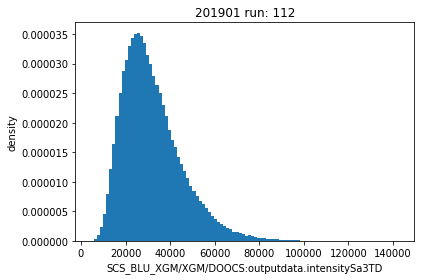

In [7]:
myDSSC.plot_xgm_hist(100)

In [8]:
myDSSC.xgm_filter(1000, 100000)

Rejecting 125 out of 9154 trains due to xgm thresholds: [1000, 100000]


In [9]:
myDSSC.define_scan('PP800_DelayLine', 0.05)

In [10]:
myDSSC.crunch()

processing 1024 trains per chunk
start time: 17:39:12
                


finished: 17:45:16


In [11]:
myDSSC.save(save_folder='/home/lleguy/temp/', overwrite=True)

saving:  /home/lleguy/temp/run112_by-delay_el.h5


# Load aggregated data

In [4]:
myDSSC.load_mask('/gpfs/exfel/exp/SCS/201901/p002313/scratch/giuseppe/dssc_mask_static_2313_12.bmp')

In [26]:
import xarray as xr
import os

darkrun_nr = 109
#run_nr = 112 #delay scan
run_nr = 108 #energy scan

datadir = '/home/lleguy/temp/' #'/gpfs/exfel/exp/SCS/201901/p002384/usr/condensed_runs'

dark = xr.open_dataset(os.path.join(datadir, f'run{darkrun_nr}_el.h5'), group='data')
image = xr.open_dataset(os.path.join(datadir, f'run{run_nr}_by-delay_el.h5'), group='data')

image['pumped'] = (image.pumped - dark.pumped.values)
image['unpumped'] = (image.unpumped - dark.unpumped.values)

# image['pumped'] = image.pumped
# image['unpumped'] = image.unpumped

<IPython.core.display.Javascript object>


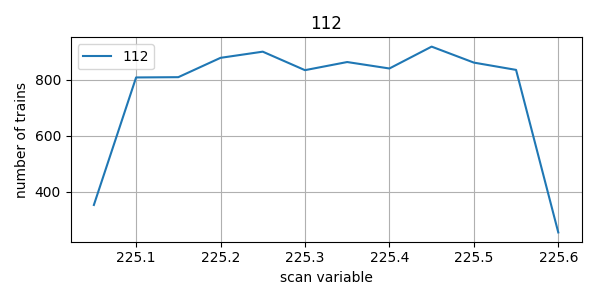

In [6]:
fig, ax = plt.subplots(figsize=[6, 3])

runstr = '+'.join([str(i) for i in [image.run.values]])
ax.plot(image.scan_variable, image.sum_count[:, 0], label = runstr)

ax.set_xlabel('scan variable')
ax.set_ylabel('number of trains')
ax.grid(True)
ax.set_title(runstr)

plt.legend()
plt.tight_layout()

## normalize by xgm

In [27]:
im_pumped = image.pumped / image.xgm_pumped
im_unpumped = image.unpumped / image.xgm_unpumped

In [8]:
image

<xarray.Dataset>
Dimensions:        (module: 16, scan_variable: 12, x: 128, y: 512)
Coordinates:
  * scan_variable  (scan_variable) float64 225.1 225.1 225.2 ... 225.6 225.6
  * module         (module) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Dimensions without coordinates: x, y
Data variables:
    pumped         (scan_variable, module, x, y) float64 -0.02217 ... 0.004766
    unpumped       (scan_variable, module, x, y) float64 -0.03145 ... -0.007328
    sum_count      (scan_variable, module) float64 ...
    run            int64 112
    xgm_pumped     (scan_variable) float32 ...
    xgm_unpumped   (scan_variable) float32 ...

## get a single averaged image to align the azimuthal integration

In [9]:
geom = myDSSC.load_geom()

In [10]:
test, _ = geom.position_modules_fast(image.unpumped[0])

plt.figure(figsize=(8,8))
vmin, vmax = np.percentile(test[~np.isnan(test)], [10, 98])
plt.imshow(test, vmin=vmin, vmax=vmax, aspect=204/236)
plt.colorbar()

<IPython.core.display.Javascript object>

In [28]:
im_unpump_mean, center = geom.position_modules_fast(im_unpumped.mean('scan_variable'))
im_pump_mean, center = geom.position_modules_fast(im_pumped.mean('scan_variable'))

<IPython.core.display.Javascript object>


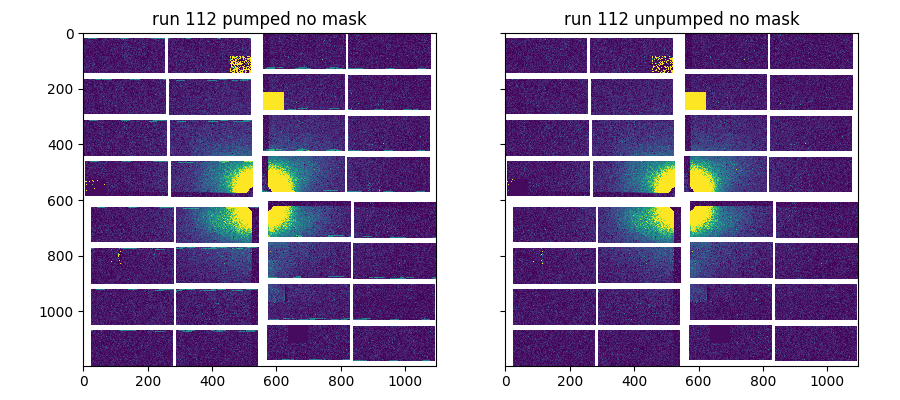

In [13]:
from time import strftime

# angle_range = [24, 75]
angle_range = [0, 179]

ai = tb.azimuthal_integrator(im_pump_mean.shape, center, angle_range, dr=1)
norm = ai(~np.isnan(im_pump_mean))

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(9, 4), sharex=True, sharey=True)

vmin, vmax = np.percentile(im_unpump_mean[~np.isnan(im_pump_mean)], [10, 98])
ax1.imshow(im_pump_mean, vmin=vmin, vmax=vmax, aspect=204/236)
ax1.set_title(f'run {runstr}'+' pumped no mask')

#vmin, vmax = np.percentile(im_unpump_mean[~np.isnan(im_unpump_mean)], [10, 98])
ax2.imshow(im_unpump_mean, vmin=vmin, vmax=vmax, aspect=204/236)
ax2.set_title(f'run {runstr}'+' unpumped no mask')

runstr = '+'.join([str(i) for i in [image.run.values]])

plt.tight_layout()

tstamp = strftime('%y%m%d_%H%M')
# fig.savefig(f'images/run{runstr}_{tstamp}_mean.png', dpi=300)

In [14]:
# angle_range = [24, 75]
angle_range = [0, 179]

ai = tb.azimuthal_integrator(im_pump_mean.shape, center, angle_range, dr=1)
norm = ai(~np.isnan(im_pump_mean))

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(9, 4), sharex=True, sharey=True)

vmin, vmax = np.percentile(im_pump_mean[~np.isnan(im_pump_mean)], [1, 98])
ax1.imshow(myDSSC.mask * im_pump_mean, vmin=vmin, vmax=vmax, aspect=204/236)
ax1.set_title(f'run {runstr}'+' pumped mask on')

#vmin, vmax = np.percentile(im_unpump_mean[~np.isnan(im_unpump_mean)], [10, 98])
ax2.imshow(myDSSC.mask * im_unpump_mean, vmin=vmin, vmax=vmax, aspect=204/236)
ax2.set_title(f'run {runstr}'+' unpumped mask on')

runstr = '+'.join([str(i) for i in [image.run.values]])

plt.tight_layout()

tstamp = strftime('%y%m%d_%H%M')
# fig.savefig(f'images/run{runstr}_{tstamp}_mean.png', dpi=300)

<IPython.core.display.Javascript object>

## azimuthal integration for each delay

In [29]:
from tqdm.auto import tqdm

az_pump = []
az_unpump = []
az_time = []

im_pumped_arranged = geom.position_modules_fast(im_pumped.values)[0]
im_unpumped_arranged = geom.position_modules_fast(im_unpumped.values)[0]

im_pumped_arranged[530:570, 615:790] = np.nan
im_unpumped_arranged[530:570, 615:790] = np.nan

for i in tqdm(range(len(im_pumped.scan_variable))):
    az_pump.append(ai(myDSSC.mask * im_pumped_arranged[i]) / norm)
    az_unpump.append(ai(myDSSC.mask * im_unpumped_arranged[i]) / norm)
    az_time.append(im_pumped.scan_variable[i])

az_pump = np.stack(az_pump)
az_unpump = np.stack(az_unpump)
az_time = np.stack(az_time)

In [30]:
coords = {'delay': az_time, 'distance': ai.distance}
azimuthal = xr.DataArray(az_pump, dims=['delay', 'distance'], coords=coords)
azimuthal = azimuthal.to_dataset(name='pumped')
azimuthal['unpumped'] = xr.DataArray(az_unpump, dims=['delay', 'distance'], coords=coords)
azimuthal = azimuthal.transpose('distance', 'delay')

t0 = 225.5
#azimuthal['delay'] = (t0 - azimuthal.delay)*6.6
azimuthal['delay'] = azimuthal.delay

wl = 1.59e-9
azimuthal['delta_q'] = 2e-9 * np.pi * np.sin(np.arctan(azimuthal.distance * 204e-6 / 530e-3)) / wl
#azimuthal['delta_q'] = azimuthal.distance

azimuthal = azimuthal.swap_dims({'distance': 'delta_q'})

In [17]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, sharey=True)

xr.plot.imshow(azimuthal.pumped, ax=ax1, vmin=0, vmax=0.0001)
xr.plot.imshow(azimuthal.unpumped, ax=ax2, vmin=0, vmax=0.0001)

ax1.set_xlabel('')
ax2.set_xlabel('delay (ps)')
ax1.set_title(f'run {runstr}')

runstr = '+'.join([str(i) for i in [image.run.values]])
plt.tight_layout(.5)

tstamp = strftime('%y%m%d_%H%M')
#fig.savefig(f'images/run{runstr}_{tstamp}_dark{darkrun_nr}_azimuthal.png', dpi=300)

<IPython.core.display.Javascript object>

## plot vs delay

<IPython.core.display.Javascript object>


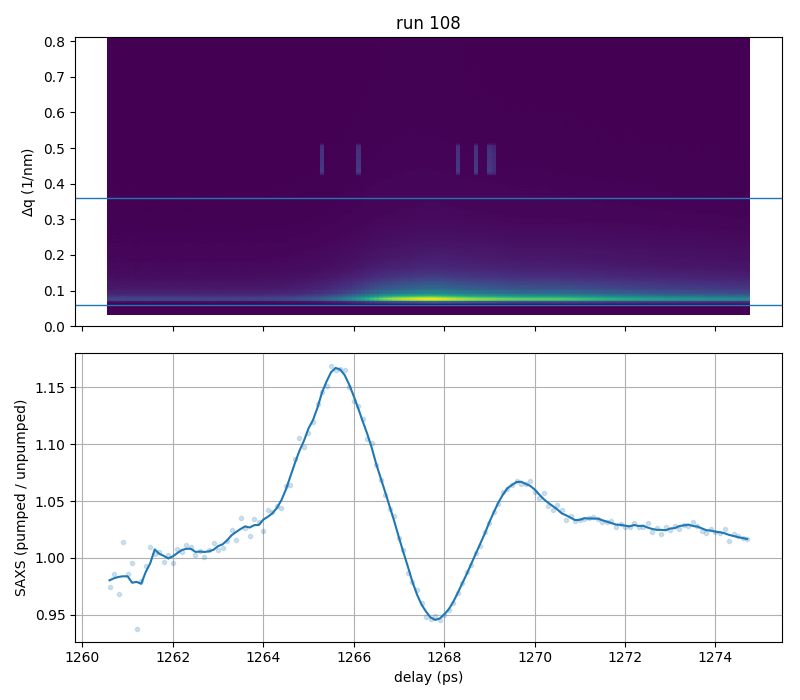

In [31]:
from scipy.signal import savgol_filter
# qranges = np.linspace(80, 480, 8)
qranges = [0.06]
qwidth = 0.3

#time = [-1.5, -1.0]

fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=[8, 7])

#norm = np.outer(np.ones(azimuthal.unpumped.shape[0]), np.nanmax(azimuthal.unpumped, axis = 0))
#xr.plot.imshow(azimuthal.pumped/norm  , ax=ax1, add_colorbar=True, vmin=0, vmax=0.00002)
#xr.plot.imshow(azimuthal.pumped/azimuthal.unpumped , ax=ax1, add_colorbar=True)#, vmin=.5, vmax=1.2)
#xr.plot.imshow(azimuthal.unpumped, ax=ax1, add_colorbar=False) #, vmin=.2, vmax=1.2)
xr.plot.imshow(azimuthal.pumped, ax=ax1, add_colorbar=False, vmin=0, vmax=0.00004)#, vmin=.2, vmax=1.2)

runstr = '+'.join([str(i) for i in [image.run.values]])

ax1.set_title(f'run {runstr}')
ax1.set_xlabel('')
ax1.set_ylabel('$\Delta$q (1/nm)')
for i, q0 in enumerate(qranges):
    sel = (azimuthal.delta_q > q0) * (azimuthal.delta_q < (q0 + qwidth))
    sel_temp = (azimuthal.delta_q > q0) * (azimuthal.delta_q < (q0 + qwidth))

    #val = (azimuthal2.pumped / azimuthal2.unpumped).where(sel).mean('delta_q')
    val = (azimuthal.pumped).where(sel).mean('delta_q')
    val_unpumped = (azimuthal.unpumped ).where(sel).mean('delta_q')

    if i == 0:
        demag = val.copy()
        #val = (azimuthal.pumped / azimuthal.pumped[:, -1]).where(sel).mean('distance')
        #ax2.plot(azimuthal.delay, val, '-', label=i)
        #ax2.plot(azimuthal.delay, val/val_unpumped, '-', label=i)

    w = savgol_filter(val/val_unpumped, 9, 2)
    ax2.plot(azimuthal.delay, w, c=f'C{i}')
    ax2.plot(azimuthal.delay, val/val_unpumped, '.', c=f'C{i}', alpha=0.2, label=i)
    
    ax1.axhline(q0, c=f'C{i}', lw=1)
    ax1.axhline(q0 + qwidth, c=f'C{i}', lw=1)

# ax2.legend()
ax2.set_xlabel('delay (ps)')
#ax2.set_xlabel('photon energy (eV)')
ax2.set_ylabel('SAXS (pumped / unpumped)')
ax2.grid(True)
# ax2.set_ylim(0.4, 1.1)

plt.tight_layout()

# plt.axvline(x=-103.9)
# plt.axvline(x=-103.5)

#plt.ylim((0.5,1.1))

tstamp = strftime('%y%m%d_%H%M')
#fig.savefig(f'images/run{runstr}_{tstamp}_2d-delay.png', dpi=300)

## plot versus energy difference

run 108

<IPython.core.display.Javascript object>


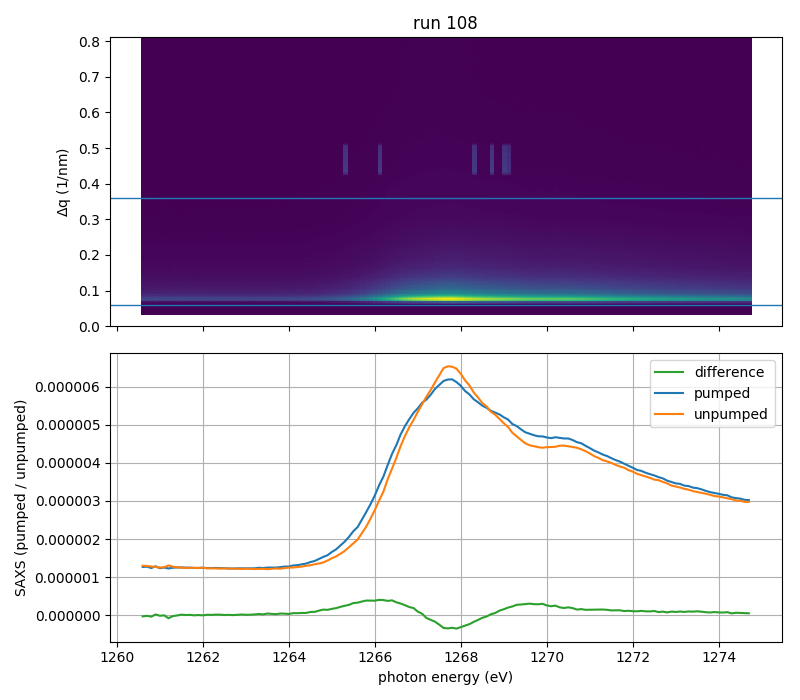

In [33]:
from scipy.signal import savgol_filter
# qranges = np.linspace(80, 480, 8)
qranges = [0.06]
qwidth = 0.3

#time = [-1.5, -1.0]

fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=[8, 7])

#norm = np.outer(np.ones(azimuthal.unpumped.shape[0]), np.nanmax(azimuthal.unpumped, axis = 0))
#xr.plot.imshow(azimuthal.pumped/norm  , ax=ax1, add_colorbar=True, vmin=0, vmax=0.00002)
#xr.plot.imshow(azimuthal.pumped/azimuthal.unpumped , ax=ax1, add_colorbar=True)#, vmin=.5, vmax=1.2)
#xr.plot.imshow(azimuthal.unpumped, ax=ax1, add_colorbar=False) #, vmin=.2, vmax=1.2)
xr.plot.imshow(azimuthal.pumped, ax=ax1, add_colorbar=False, vmin=0, vmax=0.00004)#, vmin=.2, vmax=1.2)

runstr = '+'.join([str(i) for i in [image.run.values]])

ax1.set_title(f'run {runstr}')
ax1.set_xlabel('')
ax1.set_ylabel('$\Delta$q (1/nm)')
for i, q0 in enumerate(qranges):
    sel = (azimuthal.delta_q > q0) * (azimuthal.delta_q < (q0 + qwidth))
    sel_temp = (azimuthal.delta_q > q0) * (azimuthal.delta_q < (q0 + qwidth))

    #val = (azimuthal2.pumped / azimuthal2.unpumped).where(sel).mean('delta_q')
    val = (azimuthal.pumped).where(sel).mean('delta_q')
    val_unpumped = (azimuthal.unpumped ).where(sel).mean('delta_q')

    if i == 0:
        demag = val.copy()
        #val = (azimuthal.pumped / azimuthal.pumped[:, -1]).where(sel).mean('distance')
        #ax2.plot(azimuthal.delay, val, '-', label=i)
        #ax2.plot(azimuthal.delay, val/val_unpumped, '-', label=i)

    #w = savgol_filter(val-val_unpumped, 9, 2)
    w = val - val_unpumped
    ax2.plot(azimuthal.delay, w, c=f'C{i+2}', label='difference')
    #ax2.plot(azimuthal.delay, val-val_unpumped, '.', c=f'C{i}', alpha=0.2, label=i)
    ax2.plot(azimuthal.delay, val, '-', c=f'C{i}', alpha=1, label='pumped')
    ax2.plot(azimuthal.delay, val_unpumped, '-', c=f'C{i+1}', alpha=1, label='unpumped')
    
    ax1.axhline(q0, c=f'C{i}', lw=1)
    ax1.axhline(q0 + qwidth, c=f'C{i}', lw=1)

# ax2.legend()
ax2.set_xlabel('photon energy (eV)')
#ax2.set_xlabel('photon energy (eV)')
ax2.set_ylabel('SAXS (pumped / unpumped)')
ax2.grid(True)
# ax2.set_ylim(0.4, 1.1)

plt.tight_layout()
plt.legend()
# plt.axvline(x=-103.9)
# plt.axvline(x=-103.5)

#plt.ylim((0.5,1.1))

tstamp = strftime('%y%m%d_%H%M')
#fig.savefig(f'images/run{runstr}_{tstamp}_2d-delay.png', dpi=300)